In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from networks import DiffusionNetwork
from data import LatinHyperCubeSampling
from loss_function import DiffusionLoss

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data=np.load(r'E:\Heat_diffusion_laser_metadata\30_Sep_2025_06_30_29_FBH13mm_step_size_sim_step_0_002m_p1.npz',allow_pickle=True)

Density: 1600 kg/m3 <br><br>
Specific heat capacity: 700 J/Kg*K <br><br>
Thermal conductivity kxx: 2.23 W/m*K<br><br>
Thermal conductivity kyy: 1.95 W/m*K<br><br>
Thermal conductivity kzz: 0.93 W/m*K

In [4]:
data=np.array(data['data'],dtype=np.float32)

In [5]:
data.shape

(409, 240, 320)

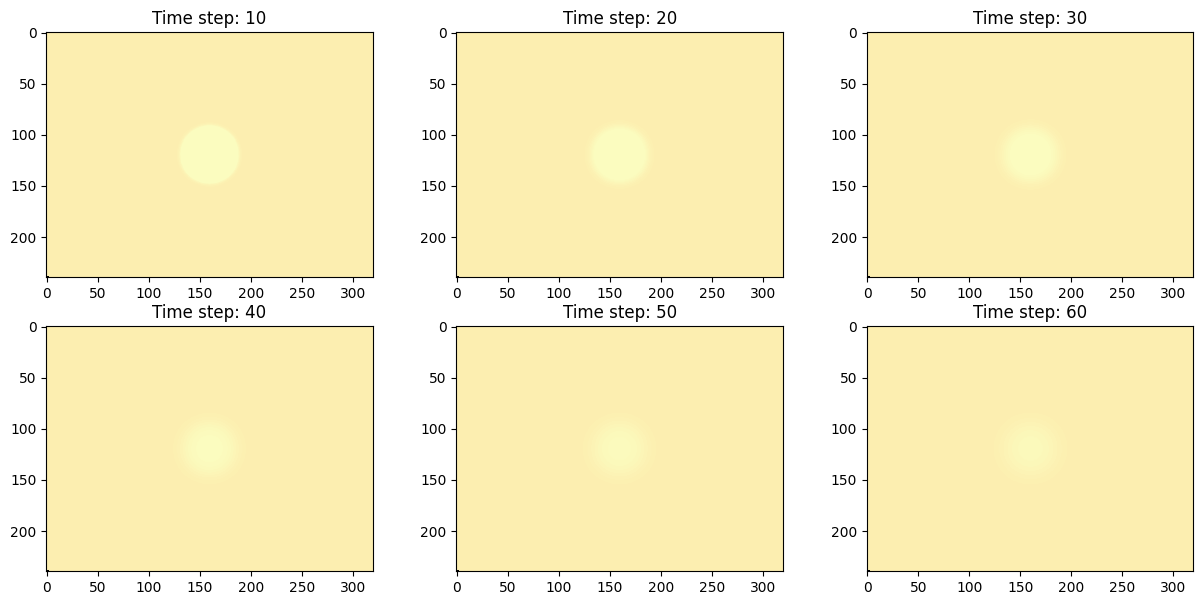

In [6]:
plt.figure(figsize=(15,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title(f'Time step: {i*10+10}')
    plt.imshow(data[i*10+10,:,:],cmap='magma',vmin=10000,vmax=30000)


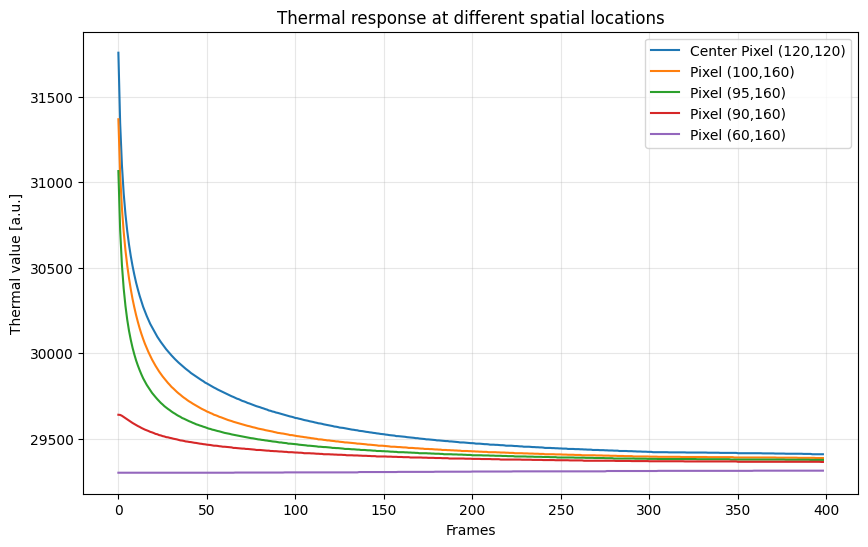

In [7]:
plt.figure(figsize=(10,6))
plt.plot(data[10:,120,160],label='Center Pixel (120,120)')
plt.plot(data[10:,100,160],label='Pixel (100,160)')
plt.plot(data[10:,95,160],label='Pixel (95,160)')
plt.plot(data[10:,90,160],label='Pixel (90,160)')
plt.plot(data[10:,60,160],label='Pixel (60,160)')
plt.grid(alpha=0.3)
plt.xlabel('Frames')
plt.ylabel('Thermal value [a.u.]')
plt.title('Thermal response at different spatial locations')
plt.legend()

In [18]:
data[10:,95:145,130:180].shape

(399, 50, 50)

In [9]:
model=DiffusionNetwork(
    input_size=3,
    output_size=1,
    hidden_layers=8,
    hidden_units=30,
    hidden_units_grad2=20
)

In [10]:
model=model.to(device)

In [11]:
sampler=LatinHyperCubeSampling((409,240,320))

In [12]:
physics_loss=DiffusionLoss()

In [13]:
loss_pde=physics_loss.pde_loss(model,sampler,n_samples=100)
loss_pde

e:\Workspaces\Diffusivity_estimation\venv_pc\Lib\site-packages\torch\autograd\graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


tensor(0.3729, device='cuda:0', grad_fn=<MeanBackward0>)